In [1]:
#setting for google colab
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive  -o nonempty

In [3]:
# Check GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
# Run some setup code for this notebook.

import random
import numpy as np
from drive.Stanford.CS231n_master.assignment1.cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [5]:
!sh drive/Stanford/CS231n_master/assignment1/cs231n/datasets/get_datasets.sh

--2018-05-25 04:16:58--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  3.27MB/s    in 51s     

2018-05-25 04:17:49 (3.22 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [6]:
 !ls

cifar-10-batches-py  datalab  drive


## CIFAR-10 Data Loading and Preprocessing

In [6]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print ('Training data shape: ', X_train.shape)
print ('Training labels shape: ', y_train.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


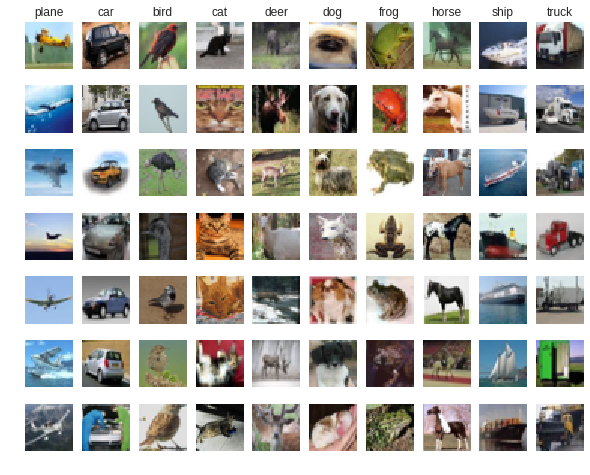

In [7]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [8]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]


# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]
#print(X_test[49001])
print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [9]:
# Preprocessing: reshape the image data into rows
# 
X_train = np.reshape(X_train, (X_train.shape[0], -1)) # ˇ32 * 32 * 3 全部塞進以X_train 為基準的向量
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print ('Training data shape: ', X_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Test data shape: ', X_test.shape)
print ('dev data shape: ', X_dev.shape)
print("X_dev",X_dev[0])

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)
X_dev [182. 171. 133. ... 201. 199. 131.]


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


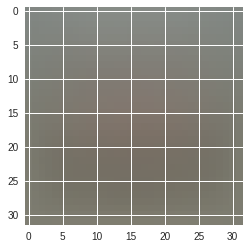

In [10]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0) # 對每個row 取出做平均
print (mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [11]:
#https://www.zhihu.com/question/49096923
# second: subtract the mean image from train and test data
print(mean_image)
print("x train",X_train)
X_train -= mean_image
print("xtrain " ,X_train)
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

[130.64189796 135.98173469 132.47391837 ... 126.64218367 125.86195918
 114.39957143]
x train [[ 59.  62.  63. ... 123.  92.  72.]
 [154. 177. 187. ... 143. 133. 144.]
 [255. 255. 255. ...  80.  86.  84.]
 ...
 [ 61.  73.  76. ... 184. 160. 117.]
 [ 10.   4.  14. ... 175. 174. 205.]
 [175. 193. 229. ...  91.  78.  90.]]
xtrain  [[ -71.64189796  -73.98173469  -69.47391837 ...   -3.64218367
   -33.86195918  -42.39957143]
 [  23.35810204   41.01826531   54.52608163 ...   16.35781633
     7.13804082   29.60042857]
 [ 124.35810204  119.01826531  122.52608163 ...  -46.64218367
   -39.86195918  -30.39957143]
 ...
 [ -69.64189796  -62.98173469  -56.47391837 ...   57.35781633
    34.13804082    2.60042857]
 [-120.64189796 -131.98173469 -118.47391837 ...   48.35781633
    48.13804082   90.60042857]
 [  44.35810204   57.01826531   96.52608163 ...  -35.64218367
   -47.86195918  -24.39957143]]


In [12]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
print (X_train.shape)
#假設沒有b會怎麼樣呢，如果直線沒有偏移量，那意味著所有的直線都要通過原點
#下面的方法  已經將 矩陣 W b 一起做計算 
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]) #X_train.shape[0] 會建立一個49000 row的 1..透過hstack 在所有col 最後面再加一個維度 給bias  Q 一個49000 的row 
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
print(X_dev[0])
print (X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3072)
[51.35810204 35.01826531  0.52608163 ... 73.13804082 16.60042857
  1.        ]
(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [0]:
import numpy as np
from random import shuffle

def svm_loss_naive(W, X, y, reg):
  """
  Structured SVM loss function, naive implementation (with loops).

  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.

  Inputs:
  - W: A numpy array of shape (D, C) containing weights.
  - X: A numpy array of shape (N, D) containing a minibatch of data.
  - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss as single float
  - gradient with respect to weights W; an array of same shape as W
  """
  dW = np.zeros(W.shape) # initialize the gradient as zero

  # compute the loss and the gradient
  num_classes = W.shape[1]
  num_train = X.shape[0]
  loss = 0.0
  for i in range(num_train):
    scores = X[i].dot(W) # X[i] 表示每一張照片的3073 rows 跟 w.shape(3073,10) 做內積   
                         #x[i]的每一行3073個維度 都會乘上10個類別 個別的3073個row 得到一個數值    算出每一個類別的分數  
    #print("scores :\n",scores)
    correct_class_score = scores[y[i]] #把第一張的真實答案 透過one hot encoding 找到第幾個類別是正確的  再透過 scores[y[i]] 得知 在正確類別的計算 得分是多少
    for j in range(num_classes): #共10個
      if j == y[i]:  # 簡而言之  在正確的類別上 我不想做margin 計算
        continue
      margin = scores[j] - correct_class_score + 1 # note delta = 1  如果margin>0 代表該錯誤類別得分高於 正確類別的分數 所以要修正W   +1 因為確保差異夠大 接下來 if margin > 0
      #SVM只关心差距至少要大于1   https://blog.csdn.net/han784851198/article/details/53332301
      if margin > 0: #大於0的
        loss += margin #loss 會累加
       
        #∂l/∂Wj=xi
        dW[:, j] += X[i] #dW[:, j] 此時會存放 X[i] 的3073的維度 內容   dw 內的3073 row 裡面存放了 x[i]的3073 個的 col 數值   這邊對應vec的 
        #print("dW[:, j] :",dW[:, j])
        
        #∂l/∂Wyi=−xi
        dW[:, y[i]] += -X[i]  # dW[:, y[i]] 把dW真正類別的col 加上 取反後的-X[i]      為什麼????
       # print(" dW[:, y[i] :", dW[:, y[i])

  #dW的求法是在一个零矩阵上加上对应的Xi（j<>yi），或者 #减去若干个 Xi（j==yi)    
  
  #正則化項(regularization penalty R(W))，最常見的正則化項是L2範數，它會對幅度很大的特徵權重給很高的懲罰
  # Right now the loss is a sum over all training examples, but we want it
  # to be an average instead so we divide by num_train.
  loss /= num_train # loss 裝者的是 每一個類別 在錯誤類的得分 減去 正確分類的得分 數的總和    除上 num_train 得到平均loss
  print("before dW:\n",dW)
  dW /= num_train #dW 存放的是 錯誤類別得分的原始數值     (另一個版本答案無此作法)
  print("dW:\n",dW)
  print("num_train:\n",num_train)
  # Add regularization to the loss.
  loss += 0.5 * reg * np.sum(W * W) # regularization 公式  reg 為超參數    L2的公式
  dW += reg * W # dW 要重新加上 reg * W       (另一個版本答案無此作法)
  

#   假定我們的輸入圖片畫素矩陣是x=[1,1,1,1]，而現在我們有兩組不同的W權重引數中對應的向量w1=[1,0,0,0]，w2=[0.25,0.25,0.25,0.25]。
#   那我們很容易知道wT1x=wT2x=1，所以不加正則項的時候，這倆得到的結果是完全一樣的，也就意味著——它們是等價的。但是加了正則項之後，
#   我們發現w2總體的損失函式結果更小(因為4*0.25^2<1)，於是我們的系統會選擇w2，這也就意味著系統更『喜歡』權重分佈均勻的引數，
#   而不是某些特徵權重明顯高於其他權重(佔據絕對主導作用)的引數。
#   之後的系列裡會提到，這樣一個平滑的操作，實際上也會提高系統的泛化能力，讓其具備更高的通用性，而不至於在訓練集上過擬合。

  #############################################################################
  # TODO:                                                                     #
  # Compute the gradient of the loss function and store it dW.                #
  # Rather that first computing the loss and then computing the derivative,   #
  # it may be simpler to compute the derivative at the same time that the     #
  # loss is being computed. As a result you may need to modify some of the    #
  # code above to compute the gradient.                                       #
  #############################################################################
  

  return loss, dW


def svm_loss_vectorized(W, X, y, reg):
  
  """
  Structured SVM loss function, vectorized implementation.

  Inputs and outputs are the same as svm_loss_naive.
  """
  loss = 0.0
  dW = np.zeros(W.shape) # initialize the gradient as zero
  num_train = X.shape[0]
  # num_train = 500     num_train.shape(500,3073)
  #y=500
  #############################################################################
  # TODO:                                                                     #
  # Implement a vectorized version of the structured SVM loss, storing the    #
  # result in loss.                                                           #
  #############################################################################
  scores = X.dot(W) #
  print("inside SVM y = \n",y)
  print("inside SVM y.shape = \n",y.shape)
  print("type y = \n",type(y))
  print("scores.shape :\n",scores.shape)
  #print("scores[np.arange(num_train), y].reshape(num_train, 1) :",scores[np.arange(num_train), y].reshape(num_train, 1))
  #scores[np.arange(num_train), y] 是一種廣播 所以shape 需要相同  看起來他會把該矩陣內的指定位置 的數值 讀取出來 reshape 並放置進 500,1 內
  margin = scores - scores[np.arange(num_train), y].reshape(num_train, 1) + 1 #score 裡面存放 3073個值 -  scores[range(500),500].reshape(500,1)
  print("margin.shape : \n",margin.shape)
  print("inside margin : \n",margin)
  margin[np.arange(num_train), y] = 0.0 #这一列不该计算，归零 因為loss不需要計算正確類別的分數 
  margin = (margin > 0) * margin # 透過 margin >0 變成boolean ...把負值 全部篩掉
  loss += margin.sum() / num_train
  loss += 0.5 * reg * np.sum(W * W)
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################


  #############################################################################
  # TODO:                                                                     #
  # Implement a vectorized version of the gradient for the structured SVM     #
  # loss, storing the result in dW.                                           #
  #                                                                           #
  # Hint: Instead of computing the gradient from scratch, it may be easier    #
  # to reuse some of the intermediate values that you used to compute the     #
  # loss.                                                                     #
  #############################################################################
  margin = (margin > 0) * 1  # 因為裡面的數值都小於1     500,10   裡面所有大於0都變1 小於 0 都變0
  #print("before row_sum :",row_sum)
  row_sum = np.sum(margin, axis=1)        #       每一張照片的10個分數 大於0的數量 做加總
  print("after row_sum :",row_sum)
  print("row_sum.shape :",row_sum.shape)
  margin[np.arange(num_train), y] = -row_sum # 把一張照片 的y lable(不是1就是0)  去剪掉 每一張照片 所有分類大於0的數量()
  print("margin :",margin)
  dW = X.T.dot(margin)/num_train + reg * W  # X.T    3073,500 dot 500,10  每一張照片的第0個像素 乘上 每一個類別在每一個分類上的的分數(但裡面已經是1或0 在y上 可能是-XX)
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################

  return loss, dW

In [14]:
# Evaluate the naive implementation of the loss we provided for you:
#from drive.Stanford.CS231n_master.assignment1.cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001   #總共有3073個rows   但是只有10個col(類別)
print("X_dev.shape :",X_dev.shape)
print("y_dev.shape :",y_dev.shape)
print("W.shape :",W.shape) 
print("y_dev[0] :",y_dev[0])

print("X_dev[1].shape:",X_dev[1].shape)
print("y_dev[0]:",y_dev[11])  #y_dev[i] 裡面記錄每一張圖片的one hot enconding 答案
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.00001)
print ('loss: %f' % (loss, ))

X_dev.shape : (500, 3073)
y_dev.shape : (500,)
W.shape : (3073, 10)
y_dev[0] : 4
X_dev[1].shape: (3073,)
y_dev[0]: 4
before dW:
 [[-9.94392569e+03 -1.34045210e+03 -1.21608863e+03 ...  3.51249776e+02
  -7.90871620e+03 -1.94509114e+04]
 [-1.57349452e+04  1.62919173e+03 -1.27560724e+03 ... -4.71324184e+02
  -1.36330365e+04 -2.14053928e+04]
 [-2.78814218e+04  2.66917918e+02  3.49391669e+03 ...  1.17246502e+03
  -2.27100522e+04 -2.81539167e+04]
 ...
 [-1.13615859e+04 -1.31666604e+03 -2.22991665e+03 ... -1.40689249e+03
   1.25227239e+04  2.56491665e+03]
 [-1.86641987e+04 -4.30344243e+03  2.64065614e+03 ...  8.45221586e+03
   1.71179914e+03 -1.09665614e+03]
 [ 3.00000000e+00 -9.90000000e+01  1.31000000e+02 ...  3.70000000e+01
  -2.00000000e+00 -1.31000000e+02]]
dW:
 [[-1.98878514e+01 -2.68090420e+00 -2.43217727e+00 ...  7.02499551e-01
  -1.58174324e+01 -3.89018227e+01]
 [-3.14698904e+01  3.25838347e+00 -2.55121449e+00 ... -9.42648367e-01
  -2.72660731e+01 -4.28107855e+01]
 [-5.57628435e+01  5

In [0]:
import numpy as np
from random import randrange
#是一個很好的debug tool
def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
  """ 
  a naive implementation of numerical gradient of f at x 
  - f should be a function that takes a single argument
  - x is the point (numpy array) to evaluate the gradient at
  """ 

  fx = f(x) # evaluate function value at original point
  print("fx : \n",fx)
  grad = np.zeros_like(x) #　依据给定数组(a)的形状和类型返回一个新的元素全部为1的数组。
  # iterate over all indexes in x
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  print("it : \n",it)
  while not it.finished:

    # evaluate function at x+h
    ix = it.multi_index
    print("ix : \n",ix)
    oldval = x[ix]
    print("oldval : \n",oldval)
    x[ix] = oldval + h # increment by h
    print("x[ix] : \n",x[ix])
    fxph = f(x) # evalute f(x + h)
    print("fxph : \n",fxph)
    x[ix] = oldval - h
    fxmh = f(x) # evaluate f(x - h)
    print("fxmh : \n",fxmh)
    x[ix] = oldval # restore

    # compute the partial derivative with centered formula
    grad[ix] = (fxph - fxmh) / (2 * h) # the slope
    if verbose:
      print (ix, grad[ix])
    it.iternext() # step to next dimension

  return grad


def eval_numerical_gradient_array(f, x, df, h=1e-5):
  """
  Evaluate a numeric gradient for a function that accepts a numpy
  array and returns a numpy array.
  """
  grad = np.zeros_like(x)
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:
    ix = it.multi_index
    
    oldval = x[ix]
    x[ix] = oldval + h
    pos = f(x).copy()
    x[ix] = oldval - h
    neg = f(x).copy()
    x[ix] = oldval
    
    grad[ix] = np.sum((pos - neg) * df) / (2 * h)
    it.iternext()
  return grad


def eval_numerical_gradient_blobs(f, inputs, output, h=1e-5):
  """
  Compute numeric gradients for a function that operates on input
  and output blobs.
  
  We assume that f accepts several input blobs as arguments, followed by a blob
  into which outputs will be written. For example, f might be called like this:

  f(x, w, out)
  
  where x and w are input Blobs, and the result of f will be written to out.

  Inputs: 
  - f: function
  - inputs: tuple of input blobs
  - output: output blob
  - h: step size
  """
  numeric_diffs = []
  for input_blob in inputs:
    diff = np.zeros_like(input_blob.diffs)
    it = np.nditer(input_blob.vals, flags=['multi_index'],
                   op_flags=['readwrite'])
    while not it.finished:
      idx = it.multi_index
      orig = input_blob.vals[idx]

      input_blob.vals[idx] = orig + h
      f(*(inputs + (output,)))
      pos = np.copy(output.vals)
      input_blob.vals[idx] = orig - h
      f(*(inputs + (output,)))
      neg = np.copy(output.vals)
      input_blob.vals[idx] = orig
      
      diff[idx] = np.sum((pos - neg) * output.diffs) / (2.0 * h)

      it.iternext()
    numeric_diffs.append(diff)
  return numeric_diffs


def eval_numerical_gradient_net(net, inputs, output, h=1e-5):
  return eval_numerical_gradient_blobs(lambda *args: net.forward(),
              inputs, output, h=h)


def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
  """
  sample a few random elements and only return numerical
  in this dimensions.
  """

  for i in range(num_checks):
    ix = tuple([randrange(m) for m in x.shape])

    oldval = x[ix]
    x[ix] = oldval + h # increment by h
    fxph = f(x) # evaluate f(x + h)
    x[ix] = oldval - h # increment by h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] = oldval # reset

    grad_numerical = (fxph - fxmh) / (2 * h)
    grad_analytic = analytic_grad[ix]
    rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
    print ('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [16]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
#from drive.Stanford.CS231n_master.assignment1.cs231n.gradient_check import grad_check_sparse
print("X_dev.shape :\n",X_dev.shape)
print("y_dev.shape :\n",y_dev.shape)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
print("f : \n",f)
#透過學校提供的function 確認 梯度 計算是否正確
grad_numerical = grad_check_sparse(f, W, grad)

#加上regularization 後 確認其計算是否正確
# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad)

before dW:
 [[-9.94392569e+03 -1.34045210e+03 -1.21608863e+03 ...  3.51249776e+02
  -7.90871620e+03 -1.94509114e+04]
 [-1.57349452e+04  1.62919173e+03 -1.27560724e+03 ... -4.71324184e+02
  -1.36330365e+04 -2.14053928e+04]
 [-2.78814218e+04  2.66917918e+02  3.49391669e+03 ...  1.17246502e+03
  -2.27100522e+04 -2.81539167e+04]
 ...
 [-1.13615859e+04 -1.31666604e+03 -2.22991665e+03 ... -1.40689249e+03
   1.25227239e+04  2.56491665e+03]
 [-1.86641987e+04 -4.30344243e+03  2.64065614e+03 ...  8.45221586e+03
   1.71179914e+03 -1.09665614e+03]
 [ 3.00000000e+00 -9.90000000e+01  1.31000000e+02 ...  3.70000000e+01
  -2.00000000e+00 -1.31000000e+02]]
dW:
 [[-1.98878514e+01 -2.68090420e+00 -2.43217727e+00 ...  7.02499551e-01
  -1.58174324e+01 -3.89018227e+01]
 [-3.14698904e+01  3.25838347e+00 -2.55121449e+00 ... -9.42648367e-01
  -2.72660731e+01 -4.28107855e+01]
 [-5.57628435e+01  5.33835837e-01  6.98783339e+00 ...  2.34493004e+00
  -4.54201043e+01 -5.63078334e+01]
 ...
 [-2.27231718e+01 -2.633332

before dW:
 [[-9.94392569e+03 -1.34045210e+03 -1.21608863e+03 ...  3.51249776e+02
  -7.90871620e+03 -1.94509114e+04]
 [-1.57349452e+04  1.62919173e+03 -1.27560724e+03 ... -4.71324184e+02
  -1.36330365e+04 -2.14053928e+04]
 [-2.78814218e+04  2.66917918e+02  3.49391669e+03 ...  1.17246502e+03
  -2.27100522e+04 -2.81539167e+04]
 ...
 [-1.13615859e+04 -1.31666604e+03 -2.22991665e+03 ... -1.40689249e+03
   1.25227239e+04  2.56491665e+03]
 [-1.86641987e+04 -4.30344243e+03  2.64065614e+03 ...  8.45221586e+03
   1.71179914e+03 -1.09665614e+03]
 [ 3.00000000e+00 -9.90000000e+01  1.31000000e+02 ...  3.70000000e+01
  -2.00000000e+00 -1.31000000e+02]]
dW:
 [[-1.98878514e+01 -2.68090420e+00 -2.43217727e+00 ...  7.02499551e-01
  -1.58174324e+01 -3.89018227e+01]
 [-3.14698904e+01  3.25838347e+00 -2.55121449e+00 ... -9.42648367e-01
  -2.72660731e+01 -4.28107855e+01]
 [-5.57628435e+01  5.33835837e-01  6.98783339e+00 ...  2.34493004e+00
  -4.54201043e+01 -5.63078334e+01]
 ...
 [-2.27231718e+01 -2.633332

before dW:
 [[-9.94392569e+03 -1.34045210e+03 -1.21608863e+03 ...  3.51249776e+02
  -7.90871620e+03 -1.94509114e+04]
 [-1.57349452e+04  1.62919173e+03 -1.27560724e+03 ... -4.71324184e+02
  -1.36330365e+04 -2.14053928e+04]
 [-2.78814218e+04  2.66917918e+02  3.49391669e+03 ...  1.17246502e+03
  -2.27100522e+04 -2.81539167e+04]
 ...
 [-1.13615859e+04 -1.31666604e+03 -2.22991665e+03 ... -1.40689249e+03
   1.25227239e+04  2.56491665e+03]
 [-1.86641987e+04 -4.30344243e+03  2.64065614e+03 ...  8.45221586e+03
   1.71179914e+03 -1.09665614e+03]
 [ 3.00000000e+00 -9.90000000e+01  1.31000000e+02 ...  3.70000000e+01
  -2.00000000e+00 -1.31000000e+02]]
dW:
 [[-1.98878514e+01 -2.68090420e+00 -2.43217727e+00 ...  7.02499551e-01
  -1.58174324e+01 -3.89018227e+01]
 [-3.14698904e+01  3.25838347e+00 -2.55121449e+00 ... -9.42648367e-01
  -2.72660731e+01 -4.28107855e+01]
 [-5.57628435e+01  5.33835837e-01  6.98783339e+00 ...  2.34493004e+00
  -4.54201043e+01 -5.63078334e+01]
 ...
 [-2.27231718e+01 -2.633332

before dW:
 [[-9.94392569e+03 -1.34045210e+03 -1.21608863e+03 ...  3.51249776e+02
  -7.90871620e+03 -1.94509114e+04]
 [-1.57349452e+04  1.62919173e+03 -1.27560724e+03 ... -4.71324184e+02
  -1.36330365e+04 -2.14053928e+04]
 [-2.78814218e+04  2.66917918e+02  3.49391669e+03 ...  1.17246502e+03
  -2.27100522e+04 -2.81539167e+04]
 ...
 [-1.13615859e+04 -1.31666604e+03 -2.22991665e+03 ... -1.40689249e+03
   1.25227239e+04  2.56491665e+03]
 [-1.86641987e+04 -4.30344243e+03  2.64065614e+03 ...  8.45221586e+03
   1.71179914e+03 -1.09665614e+03]
 [ 3.00000000e+00 -9.90000000e+01  1.31000000e+02 ...  3.70000000e+01
  -2.00000000e+00 -1.31000000e+02]]
dW:
 [[-1.98878514e+01 -2.68090420e+00 -2.43217727e+00 ...  7.02499551e-01
  -1.58174324e+01 -3.89018227e+01]
 [-3.14698904e+01  3.25838347e+00 -2.55121449e+00 ... -9.42648367e-01
  -2.72660731e+01 -4.28107855e+01]
 [-5.57628435e+01  5.33835837e-01  6.98783339e+00 ...  2.34493004e+00
  -4.54201043e+01 -5.63078334e+01]
 ...
 [-2.27231718e+01 -2.633332

In [17]:
!ls drive/Stanford/CS231n_master/assignment1/cs231n/

classifiers    _DS_Store	  __pycache__
datasets       features.py	  __pycache__ (b642452b)
data_utils.py  gradient_check.py  vis_utils.py


### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [20]:
#確認計算時間跟準確率 是否相同
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print ('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

#from drive.Stanford.CS231n_master.assignment1.cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print ('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print ('difference: %f' % (loss_naive - loss_vectorized))

before dW:
 [[-9.94392569e+03 -1.34045210e+03 -1.21608863e+03 ...  3.51249776e+02
  -7.90871620e+03 -1.94509114e+04]
 [-1.57349452e+04  1.62919173e+03 -1.27560724e+03 ... -4.71324184e+02
  -1.36330365e+04 -2.14053928e+04]
 [-2.78814218e+04  2.66917918e+02  3.49391669e+03 ...  1.17246502e+03
  -2.27100522e+04 -2.81539167e+04]
 ...
 [-1.13615859e+04 -1.31666604e+03 -2.22991665e+03 ... -1.40689249e+03
   1.25227239e+04  2.56491665e+03]
 [-1.86641987e+04 -4.30344243e+03  2.64065614e+03 ...  8.45221586e+03
   1.71179914e+03 -1.09665614e+03]
 [ 3.00000000e+00 -9.90000000e+01  1.31000000e+02 ...  3.70000000e+01
  -2.00000000e+00 -1.31000000e+02]]
dW:
 [[-1.98878514e+01 -2.68090420e+00 -2.43217727e+00 ...  7.02499551e-01
  -1.58174324e+01 -3.89018227e+01]
 [-3.14698904e+01  3.25838347e+00 -2.55121449e+00 ... -9.42648367e-01
  -2.72660731e+01 -4.28107855e+01]
 [-5.57628435e+01  5.33835837e-01  6.98783339e+00 ...  2.34493004e+00
  -4.54201043e+01 -5.63078334e+01]
 ...
 [-2.27231718e+01 -2.633332

In [21]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print ('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print ('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print ('difference: %f' % difference)

before dW:
 [[-8.05343241e+03 -6.25443241e+03 -5.53400627e+03 ...  2.68256043e+03
  -7.50927037e+03 -1.82589257e+04]
 [-1.44630731e+04 -4.71107306e+03 -4.07247949e+03 ...  5.81507143e+01
  -1.36307078e+04 -2.07289452e+04]
 [-2.49961043e+04 -6.15010433e+03  3.16738739e+03 ... -4.58568571e+01
  -2.24485827e+04 -2.67124218e+04]
 ...
 [-4.03955216e+03 -7.01855216e+03 -3.53181306e+02 ...  2.89169657e+03
   5.86520865e+03  3.38741412e+03]
 [-1.29354017e+04 -9.20040171e+03  3.64536529e+03 ...  9.33782700e+03
  -2.87139314e+03  2.61680129e+03]
 [-4.00000000e+00 -4.00000000e+00 -8.10000000e+01 ...  6.30000000e+01
   1.60000000e+01  3.00000000e+00]]
dW:
 [[-1.61068648e+01 -1.25088648e+01 -1.10680125e+01 ...  5.36512086e+00
  -1.50185407e+01 -3.65178514e+01]
 [-2.89261461e+01 -9.42214612e+00 -8.14495898e+00 ...  1.16301429e-01
  -2.72614155e+01 -4.14578904e+01]
 [-4.99922087e+01 -1.23002087e+01  6.33477478e+00 ... -9.17137143e-02
  -4.48971654e+01 -5.34248435e+01]
 ...
 [-8.07910433e+00 -1.403710

### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [24]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
#from drive.Stanford.CS231n_master.assignment1.cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
print("X_train.shape :",X_train.shape)
print("y_train.shape :",y_train.shape)
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print ('That took %fs' % (toc - tic))

X_train.shape : (49000, 3073)
y_train.shape : (49000,)
num_classes : 10

loss  793.7439920705839
grad  [[ 11.31940033  30.23197024 -73.94381543 ...  76.73472575  12.78416168
   16.68718556]
 [-46.83901715  84.8295841  100.6724671  ...  -0.97870884  72.68095597
  -21.46463875]
 [-11.65799798 136.74992995  30.37838733 ... -24.95103956  -4.62335866
  -51.79642236]
 ...
 [-16.47635789  26.32848201  80.75423941 ...  62.81171236  37.73432702
  -10.17991809]
 [-69.43640879 -32.80671233 -49.89755526 ...  14.85110936 -87.03403352
  -33.99298131]
 [ 73.57080475 -19.81784065  -5.87159538 ... -18.54490492  95.04280388
  -29.74950006]]
iteration 0 / 1500: loss 793.743992
loss  783.8095104001122
grad  [[ 26.34064129  44.65118192 -72.75521094 ...  76.03946304  19.25426057
   21.3594927 ]
 [-33.17018737  89.09071016 103.70828282 ...   3.7399291   73.76428639
  -14.4467676 ]
 [  2.20477038 131.97907152  33.98782172 ...  -8.42843762  -1.08026411
  -40.4916578 ]
 ...
 [ -7.97673692  25.48391021  75.00925

loss  411.07043917840264
grad  [[ 19.48716288  57.98893346 -73.51576557 ...  47.38591953  16.98715357
   27.66523487]
 [-22.36257403  94.57312121  53.25816025 ...  -5.15087228  59.39197053
   -1.06318305]
 [  5.7982448  130.28437283  -3.25483584 ... -22.55686012   7.58475448
  -23.54489759]
 ...
 [  2.66594065  33.200775    41.62526162 ...  27.48440493  29.78971426
   -4.41528242]
 [-29.3513475  -14.68971849 -54.90466642 ... -10.68063775 -53.65484775
  -22.93847026]
 [ 53.35841047 -14.29839858  -4.21423668 ... -13.16300487  68.64964055
  -21.65013709]]
loss  406.85675241123585
grad  [[ 28.32773513  50.34294134 -47.06399695 ...  30.56706514   0.33877107
   36.25211013]
 [-11.9846882   88.39571224  81.27004292 ... -21.84776639  44.06738516
    2.13596858]
 [ 15.45614603 126.09110301  29.39383018 ... -42.59035765  -5.81477868
  -24.85669596]
 ...
 [ -7.54706783  29.36822214  69.71333123 ...  27.44696699  22.43871099
   -4.71421744]
 [-41.9136829  -11.57625919 -27.80018595 ...  -8.64929671

loss  219.15431642530893
grad  [[ 10.09529415  24.31980972 -41.09558504 ...  46.32878394   1.05039491
   16.46062839]
 [-17.74039465  46.25737063  52.46648852 ...  13.04772158  37.59807869
   -6.55286539]
 [  6.70767397  65.51446157  11.557388   ...   2.57883122   5.53313727
  -21.44929461]
 ...
 [ 10.82341947  -2.11696116  39.74958623 ...  45.96167968  15.49863392
  -12.06158917]
 [-14.18170303 -35.95386247 -23.56607429 ...  16.06180759 -43.00842131
  -25.16760751]
 [ 38.95044231 -10.45076621  -3.02016446 ...  -9.83331351  49.89869382
  -15.63659543]]
loss  216.7199413882149
grad  [[ 10.77772278  25.21969679 -59.07351804 ...  26.96183564   2.34436405
   30.31981137]
 [-10.24577941  50.69217969  39.39541169 ... -12.06651244  35.55565922
    5.63099486]
 [ 14.81543968  72.51345416   4.05175433 ... -27.02512844   0.67092648
  -12.29048323]
 ...
 [  4.88120441  11.40190609  25.67753993 ...  26.90446352  18.9932432
   15.36200123]
 [-19.99577309 -21.78306745 -33.03633177 ...  -2.89047788 -

loss  118.42786371573398
grad  [[  6.70328538  19.5432784  -49.90050665 ...  24.98214124  15.36310104
    4.02802995]
 [-12.81059679  42.56755533  15.69332767 ...  -5.43736666  38.27407693
  -13.01528037]
 [  4.39638088  62.27027575 -15.43753512 ... -19.42701729  13.99156694
  -22.79811138]
 ...
 [ 18.10055516  10.35777412  11.9219925  ...  15.62313897  23.54491413
  -10.73576692]
 [  2.2028057   -8.02911468 -36.83397847 ...  -5.77357001 -17.15289868
  -22.31528822]
 [ 28.29080779  -7.84109696  -2.1409712  ...  -7.19841738  36.70473522
  -11.63025505]]
loss  117.47304289382446
grad  [[ 19.09540905   9.4684313  -36.52961646 ...   9.7258787   -6.85205824
   23.39809122]
 [ -0.28115554  24.0667497   34.06728093 ... -13.6387186   16.95524073
    8.32363174]
 [ 23.53959305  38.5964658   17.03632867 ... -26.48779567 -11.39441192
   -4.83364368]
 ...
 [  5.54577442  11.26413096  24.9000956  ...   3.93606654   4.17355405
    5.63690048]
 [-10.0310819  -10.58780411 -13.47898644 ... -22.87666788

loss  64.32500898640602
grad  [[ -7.71218437  12.4488801  -33.18728133 ...  27.91257514   4.03806586
   23.47497144]
 [-22.4767907   31.25027125  15.71286544 ...   9.57236095  19.51671442
   11.65230896]
 [ -8.2252025   52.29000264  -5.83930181 ...  -0.43866342  -0.42234073
    3.75159921]
 ...
 [  5.47862113   0.45629458  -0.41377501 ...  20.33140049  16.92410988
    1.35019402]
 [ -6.33805027 -11.71615787 -29.50792855 ...  -4.22172002 -15.23656618
   -4.93813507]
 [ 20.54258615  -5.57673977  -1.45883276 ...  -5.14953506  26.38338335
   -8.05504235]]
loss  63.85607084375544
grad  [[ -9.65622416  24.1524459  -13.02073615 ...  19.39024145  18.19219962
    1.68411852]
 [-22.21132461  37.11084642  39.87729193 ...   4.71614302  32.29486146
   -8.71597555]
 [ -9.17431506  54.96116079  21.84202572 ...   0.48587724   8.62581424
  -24.74183124]
 ...
 [  7.44173374   0.87781719  36.35810938 ...   3.36216716   7.30001096
   -6.77451817]
 [ -9.31440502 -13.91253423   0.16856395 ... -15.14157285 -

loss  35.55360983625288
grad  [[  7.65428546  16.95944542 -18.68115594 ...  10.59871805  -6.15440489
    8.44428454]
 [ -2.86147333  25.08606518  17.40128497 ...  -8.14359057   8.10817187
    2.36707194]
 [  4.11994341  35.56619819   4.5916774  ... -13.47978308  -2.03507378
    0.44055068]
 ...
 [  4.03130158   2.8980662   15.3831049  ...   8.90287373  18.01485569
    1.10821097]
 [ -9.92185422  -4.07071734  -7.18497131 ...  -2.51468302  -6.79086553
   -0.60626486]
 [ 14.63620881  -3.78320387  -1.26258911 ...  -3.57173758  18.97378731
   -5.8910269 ]]
loss  34.94100208790562
grad  [[ 1.12101009e+01 -1.43495058e+01 -2.82181217e+01 ...  1.96496770e+01
   9.12477806e+00  3.49686169e+00]
 [-3.12915219e+00 -8.80365750e+00  1.37140046e+01 ...  5.63258402e+00
   2.09313754e+01 -8.52859914e+00]
 [ 1.61114716e+00 -4.53026198e+00  8.29582779e+00 ... -2.88923212e+00
   1.22579483e+01 -1.63671292e+01]
 ...
 [ 1.28439218e+01 -9.98886372e+00  8.90911876e+00 ...  9.30181039e+00
   4.78807978e+00 -2.1

loss  18.005229035591555
grad  [[  0.70791843  -3.09670114   1.91164418 ...  10.10476859   8.74820775
   -0.87417215]
 [ -3.69282017   5.54960324  26.83908142 ...  -1.08757728  14.38068194
  -10.09630812]
 [  2.82879591  15.2071996   14.68449901 ...  -2.06532856   6.4917086
  -18.28460749]
 ...
 [ 13.53140983  -3.69584034   0.10067761 ...  10.59659202   5.53357972
  -10.35668462]
 [  4.15426264  -7.41949773 -13.76651381 ...   4.62057523  -8.3074833
  -15.680248  ]
 [  9.64067115  -2.54175273  -0.86731546 ...  -2.44377627  12.54356706
   -3.78700052]]
loss  17.467848443971526
grad  [[ -6.2498781   23.14057287 -33.62136077 ...  -9.25129688   5.43487406
   12.11253085]
 [-14.00380811  27.66194655  -6.4277395  ... -15.44385163   9.32793363
    6.530977  ]
 [ -5.05456562  30.50879401 -18.55553287 ... -17.81530723   0.47590393
    3.45975126]
 ...
 [  2.05789401   3.05832906   8.42311953 ...  11.5284564   -0.55326124
   -5.04905834]
 [ -4.19849582  -5.5043981   -8.02462553 ...  -1.7244505  -

loss  10.744336135332617
grad  [[  0.78872957  33.62928504 -19.09884032 ...   0.54869114 -14.09772554
    6.78186567]
 [ -6.77586408  42.05993644   2.48003486 ...  -2.84555773  -5.55519293
    0.4020677 ]
 [ -8.27202245  42.08239736   1.88325905 ...  -0.52177968  -9.74559326
   -7.40307771]
 ...
 [  0.69185325  10.08150797   3.94267379 ...   1.52310761   6.65760758
    3.97547745]
 [ -3.40226436  -3.34354289   0.34668079 ...  -5.27483772  -2.33048424
    2.09876246]
 [  6.28836155  -1.83490339  -0.42360215 ...  -1.29654128   8.05189756
   -2.41217896]]
loss  10.27672373935216
grad  [[ -1.43558561   3.04437943 -25.42260306 ...  12.85351707  -0.3254464
   13.0530593 ]
 [ -5.94225874   3.90194288 -11.55681736 ...   5.63819047   4.18267436
   11.42021705]
 [ -2.66355356   5.37241802 -19.4353748  ...   8.57300473  -2.09923489
    9.04952605]
 ...
 [  8.82132337   7.33131676  -6.72289835 ...   8.14407983   0.99500975
    7.71901924]
 [  1.16574053   1.07334626 -20.71703975 ...   3.1564079   

loss  7.373736943730311
grad  [[ 16.09871586   6.62009101  -4.39337431 ...   0.08343599  -5.44561842
   -5.79718823]
 [  8.92512321   9.19309939   2.35813511 ...   4.6856415   -2.99660496
   -7.65721783]
 [  7.85063685  14.00462971   1.62410184 ...   2.3003205   -6.76673447
   -9.37728227]
 ...
 [ 13.77727895   6.91918736   5.6196086  ...   8.0663972   -4.98279356
   -2.36923243]
 [  5.7871149    6.12747008   5.6716048  ...   5.34267387 -11.11715277
   -3.59527756]
 [  4.16846405  -0.87503597  -0.4254653  ...  -1.14294162   5.42139545
   -1.5955073 ]]
loss  8.080909457774732
grad  [[-14.33505435 -14.12000138  -2.74035999 ...  11.68575381  -4.37018084
   16.85797944]
 [-11.41068965  -9.43179314  10.2158878  ...   3.5416883   -1.70171326
   16.50316876]
 [ -8.76781164  -4.44850099   9.51782929 ...  -5.48729111  -9.9605312
   11.40510353]
 ...
 [ -3.7005801   13.48991265  -4.41194046 ...   3.38488521  -2.2485698
   -5.18151158]
 [ -8.42584853  11.34774058 -16.85176394 ...   3.0630655  -13

loss  6.516802534488873
grad  [[ -4.06624346  15.98601806   6.08896931 ...   7.4898232    7.26274351
  -31.51245103]
 [ -6.2072162   13.04106278  12.88736557 ...   8.79691931   7.82458386
  -29.06000017]
 [ -6.78730291  18.22278218  11.06933804 ...  10.43081317   2.79868077
  -25.14886253]
 ...
 [ -2.343727     1.48403864   7.98085413 ...   5.66479276  -4.96150753
   17.33101012]
 [ -2.18864237   5.5075543    9.1697557  ...  -1.20338817 -13.70026647
   20.62359118]
 [  2.78464373  -0.57154222  -0.08543202 ...  -0.56618862   3.452788
   -1.10337031]]
loss  5.895868748984791
grad  [[ -2.06817724   8.54223838  -1.15444778 ...   2.41774561  10.63038234
   -2.85286102]
 [ -3.76170512  12.55056053   7.12573691 ...   2.1982087    9.02091757
   -6.216892  ]
 [ -0.9494764   13.8891046    0.61586156 ...   4.87655033   2.83283941
   -8.30124801]
 ...
 [ -2.67318836   2.50158661   3.38438497 ...   5.84853941  12.69675103
  -15.85220983]
 [ -2.43059416  -1.28910776   4.43185549 ...   3.3666352    5


loss  5.667814821487987
grad  [[ -3.6702548    7.21324651 -16.49062982 ...  15.42168838   1.09499479
    6.24237292]
 [ -4.48372321   6.67547181 -13.73510423 ...  18.91894122   4.54685136
    3.37043139]
 [ -2.01420511   4.75125185 -16.60340384 ...  19.26276852   6.03301918
   -1.30983266]
 ...
 [ -4.28287948  15.7696498  -10.13884629 ... -10.29365427  13.29302749
    4.76529293]
 [ -3.87232917  13.47825199 -11.62824598 ... -15.4167489   10.94024507
    1.38020924]
 [  1.48543502  -0.51907864  -0.12939881 ...  -0.38181827   2.4130968
   -0.61984038]]
loss  5.805848579504964
grad  [[ -1.10464301  16.18596273  -1.01584453 ...  10.4624179   -6.10135753
    4.39072238]
 [ -3.10726327  12.21611282   5.26037487 ...  -1.00101879  -3.433988
    5.24202668]
 [ -0.57372368  12.64823355   2.0575489  ...  -1.53906696  -6.36657979
    5.22199956]
 ...
 [ -0.69313487  11.27617053  -8.2823092  ...  -7.98994682  10.90309542
   -2.020267  ]
 [  7.55924462  13.54795502 -14.48517975 ... -15.51667373   5

loss  5.627978481608797
grad  [[  2.0006294   19.06193934   4.5013916  ... -11.01628082  -9.8424754
    4.03849751]
 [  1.79877873  20.17903657   2.39544252 ... -11.95304314 -12.03199821
    3.15679534]
 [  3.98754266  17.55885524   1.62662837 ... -11.86010896 -16.54299104
    7.29507109]
 ...
 [  4.61984396  14.84258844  -3.64767645 ...  -2.13015742   0.8777432
  -18.10981884]
 [  2.25250328  12.29232056  -5.01618595 ...  -6.90954626  -0.98820202
  -19.65507374]
 [  1.0137539   -0.48437991   0.14844563 ...  -0.0769614    1.57124362
   -0.49939406]]
loss  5.209124781694018
grad  [[  2.1094087   15.7505822   15.09027229 ...   0.7180262  -10.64474915
    1.58769625]
 [  2.33880321  17.00359802  19.18088521 ...   1.90377667  -7.29793414
    1.04802055]
 [  6.98334291  21.24421301  14.05017135 ...   6.79034607  -9.57684098
    3.31146471]
 ...
 [  5.29711372 -11.26317348  24.568275   ...  15.19044561   2.65507203
   -8.71408525]
 [  2.22833505 -13.88913033  22.91971712 ...  17.15881504   4

loss  5.3905319573440735
grad  [[ -0.80463332 -13.14236661   4.56938921 ... -15.1834541    3.36374438
    6.40486234]
 [ -1.87801778  -9.85308882   6.54227286 ... -21.01388565   2.60073864
    3.6849394 ]
 [ -7.62503471  -6.37548637   8.03574644 ... -19.0763117    4.6492365
    0.61741109]
 ...
 [ -3.51506036 -12.08414116   6.074775   ...   8.56847731  -2.47177283
   -8.74059248]
 [ -9.37029109  -8.46980357   7.85567345 ...   8.37866672  -4.98787522
   -6.74495399]
 [  0.56418701  -0.15384939   0.07026043 ...  -0.57564122   1.00639657
   -0.15666717]]
loss  5.260977380105531
grad  [[ -5.91757076   7.5899343  -38.750011   ...   1.37779888  -1.06043781
   15.32577895]
 [ -2.49015728  12.03743224 -33.01781299 ...   0.32757664  -5.79146607
   17.38130909]
 [  1.09304597  19.91854433 -29.6528229  ...  -2.06180157 -15.83500846
   21.92439077]
 ...
 [ -6.8662573   23.17798117 -23.53854419 ...  -0.22105079   6.03883665
   -7.96123115]
 [ -5.37435821  22.20445759 -23.61666063 ...  -4.17807661  

 4.913754284629333
grad  [[ 15.3999042   18.45523653  -7.33860339 ...   0.98356409  -2.5561963
  -17.05718443]
 [ 16.87888061  17.28147761 -11.34185533 ...   0.77776763  -1.48019762
  -18.54220733]
 [ 10.04490497  19.1298487  -15.69475103 ...  11.05759799   1.3843225
  -21.26002739]
 ...
 [  5.91402324  14.374083    -4.57048656 ... -14.46210893   5.43209969
  -25.27857296]
 [  0.26584011   9.31001949 -10.68597349 ...  -2.46346964   4.24757551
  -24.51341541]
 [  0.43231991  -0.17288746   0.4178219  ...  -0.48459668   0.6305141
   -0.3674293 ]]
loss  5.337482814707424
grad  [[ -0.64648654  -5.310182     3.89187657 ...  13.5346579   -2.07223358
    0.08590364]
 [  2.13247702  -8.76355988   6.16535598 ...  14.35454103   2.39930388
    0.76625728]
 [  3.73681146  -9.48134442   4.21516028 ...  11.86539531   4.76290028
    0.64698847]
 ...
 [-10.15573136  -2.55743435  -7.91941536 ...   6.19299427   2.25081389
   13.20130276]
 [ -6.56653623  -8.30149847 -12.41976648 ...   4.69998057  -0.79961

loss  5.028473439826691
grad  [[ -8.33300503  -8.01561714  17.11706898 ... -13.58796629 -19.54466096
   -9.57994613]
 [ -8.51508037  -3.94246861  14.40476761 ... -12.12365144 -15.61749391
  -11.6160299 ]
 [-12.57422717   2.45738737  12.12382791 ... -17.21646088 -10.35194415
   -8.74379743]
 ...
 [-10.66257446  -5.01925899 -14.49804537 ...   7.15517417  -4.06882495
   -5.02307289]
 [-12.52644192  -1.76468293 -12.69333359 ...   0.91627991  -0.59737754
   -1.43506146]
 [  0.53080386  -0.14624665   0.25037857 ...  -0.09245034   0.61231632
   -0.21190596]]
loss  4.636975470709212
grad  [[-24.54174286  -7.95912007   4.0373968  ...  -0.77725564  12.29458428
   -5.07093181]
 [-25.67517639  -9.33793892  10.21473    ...  -1.24967706  11.1455706
   -6.67712781]
 [-23.75731032  -5.20016039   6.7664053  ...   2.52727407  11.45014312
  -15.18640477]
 ...
 [-12.32723873  -2.0505431    0.17666812 ...  -5.53302537  11.69855795
   -4.74174569]
 [-13.23598971   1.1331362   -0.70893763 ...  -0.93234006   

 5.430181249924838
grad  [[ -1.88147787  11.1725269   15.55104857 ...  -4.52659893   4.45336814
    6.9171994 ]
 [ -6.2043298    6.68826472  12.50157473 ...  -3.45116081   5.25747343
    4.90568042]
 [ -6.06111742   1.00808749   7.29392502 ...  -3.21592674   4.32587426
   -1.83866704]
 ...
 [ -0.87025501   4.98174737   3.62944064 ...  -0.72578961   1.506793
   -6.13032221]
 [  2.00145104   0.77184225   3.19841213 ...  -4.22732936   1.68122187
  -11.17841812]
 [  0.21261867  -0.13838187   0.34015604 ...   0.13901708   0.3162144
   -0.05733456]]
loss  5.929287324623142
grad  [[-1.34038292 12.66254161 -8.19086065 ... -1.60075645 -5.07883156
  13.04285064]
 [ 0.51662348 15.8129285  -2.46522549 ... -1.90899633 -4.21753537
  10.19886886]
 [ 3.0212302   8.14748093 -1.57117379 ... -6.22747752 -6.05892939
   6.76976609]
 ...
 [ 4.97636728  4.21030557 -3.50614616 ...  2.79714914  2.09392189
   9.3480743 ]
 [ 5.6185595   1.7150559   9.23131936 ... -0.38919485  3.94984577
   6.8574204 ]
 [ 0.48155

loss  5.217361797802357
grad  [[ 12.28256516  -4.20210377   8.05570529 ...   7.66182536  -3.50427081
   -8.31798228]
 [ 12.93885187  -6.20638186   6.24119956 ...   2.13725419  -4.80539346
  -13.79539171]
 [ 15.00955896  -2.42375282   5.7804258  ...   1.31976515  -8.36156769
  -14.22241872]
 ...
 [ -2.1731123    4.45496451   1.92779863 ... -16.7348702   -0.76722386
   -6.95341027]
 [ -0.18336449   5.89742181   0.37570584 ... -15.82001477  -3.97360224
   -5.77335021]
 [  0.51325757  -0.01719197   0.15060619 ...   0.1365414    0.18382091
   -0.19928917]]
loss  5.466004973187513
grad  [[-2.05624600e+01 -5.97714070e+00  2.57996151e-01 ...  7.72659144e+00
   9.92443228e+00 -2.56763896e-01]
 [-1.92834225e+01 -3.61989332e+00  8.18451397e+00 ...  5.34891945e+00
   1.27707340e+01 -7.19168873e+00]
 [-1.39538127e+01 -8.04348202e+00  2.00636992e+01 ...  1.28188449e+00
   1.32057395e+01 -9.59919785e+00]
 ...
 [-1.54895337e+01 -1.04338593e+01  9.75674739e+00 ... -1.44662118e+01
  -3.20751305e+00 -7.4

loss  5.259093991125718
grad  [[  8.3625263   -9.59521459   6.97939834 ...  -4.47592077   5.505556
  -10.22505313]
 [ 12.8706206  -10.21345724   6.94573604 ...  -5.34593785   1.63830456
  -14.44843382]
 [ 10.25978045 -13.76754515   9.38319673 ...  -7.744091    -1.10948081
  -11.31285666]
 ...
 [ -5.66659005   2.28452302   4.88907517 ... -19.5186167   -9.64708807
   12.29774561]
 [ -8.68571733   3.8218359    6.92256066 ... -22.14855378 -12.48645881
   11.39344818]
 [  0.06945159   0.13846276  -0.13398844 ...   0.18910848   0.03358902
   -0.13715732]]
loss  5.488047865798954
grad  [[ 5.29331439e+00 -2.24914596e+01 -9.29968845e+00 ... -2.05055331e+01
   6.48704791e+00  2.25547874e+01]
 [ 3.78318535e+00 -2.00929609e+01 -4.71716611e+00 ... -2.28581352e+01
   3.52684824e+00  1.87115481e+01]
 [ 3.90872012e+00 -1.72291623e+01 -1.28611111e+01 ... -2.49134781e+01
   5.42604435e+00  1.37676199e+01]
 ...
 [-5.83762815e-01 -1.37390020e+01 -2.98656612e+00 ...  6.44297605e-01
  -6.07573875e+00  9.141

loss  5.589719223420443
grad  [[  3.26498542 -14.88210336  -7.1397675  ...  18.09457807   9.77183912
  -10.85178418]
 [  0.2300368  -16.67106262  -4.1524478  ...  20.6271839   10.71372438
   -6.95085412]
 [ -5.47739483 -21.44748952   0.34506456 ...  20.86450674  12.3882768
   -5.72169763]
 ...
 [  5.13615427  -7.95410719   1.10896333 ...  -5.35169187   4.90370157
   -1.8184169 ]
 [  7.30222541  -9.36231727   4.14243121 ...  -4.60245386   5.80762954
   -2.92677886]
 [  0.10611469   0.22371389   0.06684709 ...   0.06303383   0.18389933
   -0.06076114]]
loss  5.341957334108731
grad  [[ -0.6105293   26.30105828 -13.63852703 ...   4.63170589  -3.03901202
   -9.38228802]
 [ -2.03928686  27.63391361 -13.09497331 ...   3.43596584  -2.84877128
   -4.40338301]
 [ -1.51239969  31.37242283  -0.54635546 ...  10.92542278  -4.75177214
   -8.63384934]
 ...
 [  3.52427758  18.50012579  -8.14642884 ...  -4.97043912  -9.17549572
    9.15842008]
 [  0.68075714  19.76841503   1.06864191 ...  -3.56139659 -1

loss  4.975726449016151
grad  [[-1.82489766e+00 -2.00315810e+01  1.03414426e+01 ... -7.16299048e+00
   1.66969436e+01 -1.07309957e+01]
 [-1.88009030e+00 -2.10130290e+01  6.33699457e+00 ... -6.09608004e+00
   1.78342065e+01 -1.05018886e+01]
 [-1.39267640e+00 -2.24772064e+01  2.35963280e+00 ... -9.65329369e+00
   1.48138705e+01 -1.30269533e+01]
 ...
 [-3.38792942e+00 -6.62541593e+00 -3.71228660e+00 ...  8.79355203e+00
   4.59978346e+00 -4.05780097e+00]
 [-1.03402178e+00 -6.40995756e+00 -8.47506547e+00 ...  4.04792315e+00
   4.54951565e+00 -6.30574700e+00]
 [ 2.82922501e-01  1.46061167e-01  2.87573248e-01 ... -3.23161415e-02
   5.04674428e-03 -4.57023585e-03]]
loss  5.39708233620438
grad  [[-0.25972573 -9.37071133 16.33905946 ... -0.36213971  5.77507932
   4.45519288]
 [ 1.20385352 -2.13981332 13.48604021 ... -4.22671851  4.61368857
   1.39126014]
 [ 0.64113494 -1.702101    4.2788779  ... -1.21626457  5.92001743
   5.7015943 ]
 ...
 [10.29055921  6.56594584 -0.45820353 ... -7.7216594  -2.

loss  5.430331811453602
grad  [[ -0.21454944 -15.39871788  -9.1232376  ...  -1.50499916 -12.91170903
   12.67670381]
 [ -2.61463721 -12.27416086  -3.94805371 ...  -0.93330579 -10.86999388
   11.6745819 ]
 [ -2.78660358 -21.10366625  -4.71585612 ...  -5.44972831  -9.74054667
   11.90755216]
 ...
 [ -1.50336488  -2.6276104    0.07901794 ...   2.33690939  -2.4149932
   -6.37660207]
 [  0.90072611   0.11547646  -0.24313142 ...   0.22073374  -2.18648019
  -10.46805061]
 [  0.21783555  -0.28106548   0.38402003 ...  -0.1075173    0.02178426
    0.08798876]]
loss  4.954281506301786
grad  [[-12.89344088  -0.56040827  10.86457644 ...   5.64462074 -11.82066437
   16.37227284]
 [-15.4126829    0.8768676   14.31093299 ...   5.59044747 -11.97954799
   17.34166562]
 [-20.57890791   0.2910029   17.24200744 ...   8.56621625  -9.60027904
   19.61116644]
 ...
 [  6.94790827  13.09572806  17.14013999 ...   1.5733228   -7.66963578
   -4.13626804]
 [  1.99507891  12.01300836  20.69894923 ...  -2.40539136  -

loss  5.4554054573279815
grad  [[ 6.10009090e+00 -5.98266903e+00  7.44555584e+00 ... -1.43799915e+01
  -8.62798181e+00  2.16008047e+01]
 [ 5.90874307e+00 -1.04545226e+01  1.19886964e+01 ... -1.48938342e+01
  -5.18097565e+00  2.43003228e+01]
 [ 1.42638754e+01 -1.49356804e+01  1.12659798e+01 ... -1.08143579e+01
  -1.22888827e+00  2.43743960e+01]
 ...
 [-5.89398447e+00  6.89915773e+00  1.23632722e+00 ... -1.12346149e+01
  -4.04468393e+00 -5.71929843e+00]
 [-2.13076762e+00  6.69975473e-01  5.20531910e+00 ... -1.59895031e+01
  -4.57630424e+00 -2.08956275e+00]
 [ 2.08537639e-01 -4.97726931e-02 -2.11029337e-01 ... -1.83703982e-02
  -7.53771382e-02 -6.69833871e-02]]
loss  5.38530324715325
grad  [[-5.09905772e+00 -5.77518630e+00  3.65700756e+00 ... -9.15234850e+00
   2.12392449e+01 -1.77963891e+01]
 [-3.01726187e+00 -5.46272959e+00  2.48761158e+00 ... -1.26938171e+01
   2.09079430e+01 -1.47093523e+01]
 [-1.09530494e-01 -1.26788265e+01 -5.02020055e+00 ... -9.50950367e+00
   2.16690596e+01 -1.543

In [23]:
import numpy as np
from drive.Stanford.CS231n_master.assignment1.cs231n.classifiers.linear_svm import *
from drive.Stanford.CS231n_master.assignment1.cs231n.classifiers.softmax import *

class LinearClassifier(object):

  def __init__(self):
    self.W = None
    
  def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this linear classifier using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - reg: (float) regularization strength.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.

    Outputs:
    A list containing the value of the loss function at each training iteration.
    """
     
    num_train, dim = X.shape # num_train    dim = 3073
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes  求序列的最大值 https://blog.csdn.net/lanchunhui/article/details/52700895
    print("num_classes :",num_classes)
    if self.W is None:
      # lazily initialize W
      print()
      self.W = 0.001 * np.random.randn(dim, num_classes) # 給予一個3073 , 10 矩陣 裡面數值隨機 

    # Run stochastic gradient descent to optimize W
    loss_history = []
    #所謂SGD  是指 在一個給定的iteration下去跑 訓練資料 隨機的batch size 
    for it in range(num_iters):
      X_batch = None
      y_batch = None

      #########################################################################
      # TODO:                                                                 #
      # Sample batch_size elements from the training data and their           #
      # corresponding labels to use in this round of gradient descent.        #
      # Store the data in X_batch and their corresponding labels in           #
      # y_batch; after sampling X_batch should have shape (dim, batch_size)   #
      # and y_batch should have shape (batch_size,)                           #
      #                                                                       #
      # Hint: Use np.random.choice to generate indices. Sampling with         #
      # replacement is faster than sampling without replacement.              #
      #########################################################################
      # 0~49000 隨機只取裡面的batch_size數量 並且可以重複 
      mask = np.random.choice(num_train, batch_size, replace=True) #replace=True: 可以从a 中反复选取同一个元素。 replace=False: a 中同一个元素只能被选取一次。
      #print("SGD mask = \n",mask)
      X_batch = X[mask] 
      y_batch = y[mask]
      #########################################################################
      #                       END OF YOUR CODE                                #
      #########################################################################

      # evaluate loss and gradient
     
      loss, grad = self.loss(X_batch, y_batch, reg)  #跑class LinearSVM 的loss
      print("loss ",loss)
      print("grad ",grad)
      
      loss_history.append(loss)
      
      #為什麼是如下作法 可以持續更新W 並找到谷坑  往她的反方向做計算梯度下降更新参数
      
      #这个grad代表的意义是，每正向改变w的值，会造成最终的目标函数有多大的改变。
      #比如这个grad是一个正数，那么自变量就是正向作用，它越大则目标函数值越大，
      #那么我们为了得到极小值，是不是就应该按照反方向来对权值（自变量）进行调整呢？
      
      # perform parameter update
      #########################################################################
      # TODO:                                                                 #
      # Update the weights using the gradient and the learning rate.          #
      #########################################################################
      self.W -= learning_rate * grad
      #########################################################################
      #                       END OF YOUR CODE                                #
      #########################################################################

      if verbose and it % 100 == 0:
        print ('iteration %d / %d: loss %f' % (it, num_iters, loss))

    return loss_history

  def predict(self, X):
    """
    Use the trained weights of this linear classifier to predict labels for
    data points.

    Inputs:
    - X: D x N array of training data. Each column is a D-dimensional point.

    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[1])
    ###########################################################################
    # TODO:                                                                   #
    # Implement this method. Store the predicted labels in y_pred.            #
    ###########################################################################
    y_pred = np.argmax(X.dot(self.W), axis=1)
    ###########################################################################
    #                           END OF YOUR CODE                              #
    ###########################################################################
    return y_pred
  
  def loss(self, X_batch, y_batch, reg):
    
    """
    Compute the loss function and its derivative. 
    Subclasses will override this.

    Inputs:
    - X_batch: A numpy array of shape (N, D) containing a minibatch of N
      data points; each point has dimension D.
    - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
    - reg: (float) regularization strength.

    Returns: A tuple containing:
    - loss as a single float
    - gradient with respect to self.W; an array of the same shape as W
    """
    pass


class LinearSVM(LinearClassifier):
  """ A subclass that uses the Multiclass SVM loss function """
  
  def loss(self, X_batch, y_batch, reg):
   
    return svm_loss_vectorized(self.W, X_batch, y_batch, reg)


class Softmax(LinearClassifier):
  """ A subclass that uses the Softmax + Cross-entropy loss function """

  def loss(self, X_batch, y_batch, reg):
    print("7777777777777777")
    return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)



4444444444444444


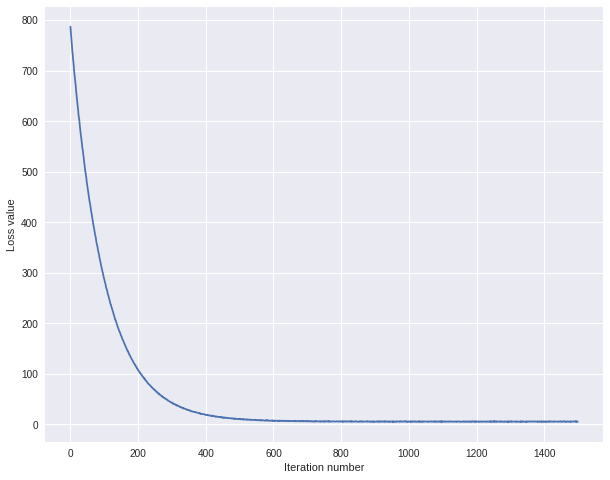

In [22]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [21]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print ('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print ('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.371388
validation accuracy: 0.385000


In [22]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 5e-6]
regularization_strengths = [5e4, 1e5]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for lr in learning_rates:
    for rs in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=rs, num_iters=1500, verbose=True)
        y_train_pred = svm.predict(X_train)
        acc_tr = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        acc_val = np.mean(y_val == y_val_pred)
        
        results[(lr, rs)] = (acc_tr, acc_val)
        if acc_val > best_val:
            best_val = acc_val
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print ('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 794.652691
iteration 100 / 1500: loss 287.713199
iteration 200 / 1500: loss 108.441882
iteration 300 / 1500: loss 42.536113
iteration 400 / 1500: loss 19.072551
iteration 500 / 1500: loss 10.381204
iteration 600 / 1500: loss 6.881619
iteration 700 / 1500: loss 6.070367
iteration 800 / 1500: loss 6.092657
iteration 900 / 1500: loss 5.011580
iteration 1000 / 1500: loss 5.461035
iteration 1100 / 1500: loss 5.694073
iteration 1200 / 1500: loss 5.234186
iteration 1300 / 1500: loss 5.450582
iteration 1400 / 1500: loss 5.350711
iteration 0 / 1500: loss 1536.078349
iteration 100 / 1500: loss 207.630090
iteration 200 / 1500: loss 32.678937
iteration 300 / 1500: loss 9.433328
iteration 400 / 1500: loss 6.001691
iteration 500 / 1500: loss 5.378244
iteration 600 / 1500: loss 5.414138
iteration 700 / 1500: loss 6.178997
iteration 800 / 1500: loss 6.084508
iteration 900 / 1500: loss 5.486210
iteration 1000 / 1500: loss 5.339218
iteration 1100 / 1500: loss 5.401206
iteration 

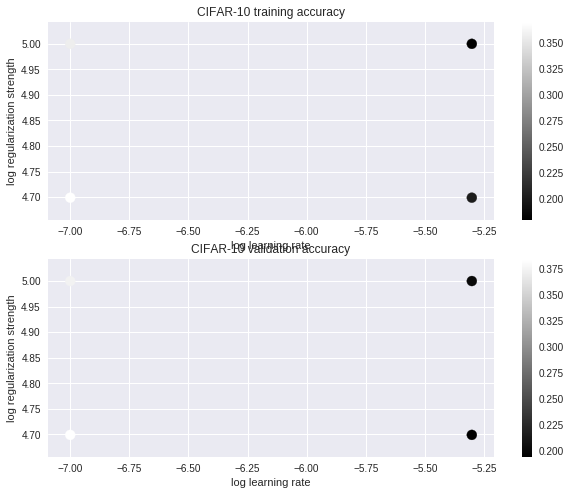

In [23]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [24]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print ('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.362000


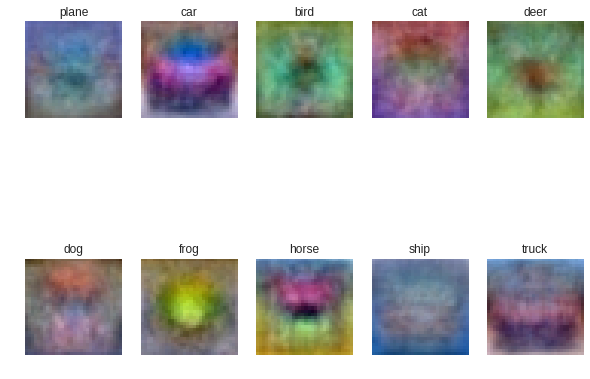

In [25]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*